# NCSEA - Transfer Learning using Visual Transformers
created: 08/18/2024

## Goal:

Successfully develop a surface roughness classifier using aerial snapshots from Google Maps. This approach leverages [transfer learning technique](https://www.ibm.com/topics/transfer-learning). Begin by adding a randomly initialized classification layer on top of a pre-trained model. Then, fine-tune the model by training only the classification layer.

This training example borrows code extensively from this [notebook](https://github.com/huggingface/notebooks/blob/main/examples/image_classification.ipynb) provided by Hugging Face. 

### Machine Learning Model

Visual Transformer: 

- google/vit-base-patch16-224-in21k
    - Documentation:
        - [google/vit-base-patch16-224-in21k · Hugging Face](https://huggingface.co/google/vit-base-patch16-224-in21k)

While running this example, you might need to adjust the batch size to avoid out-of-memory errors depending on the model and the GPU you are using.  

### Dataset

A curated dataset using snipshots from google arial view is prepared for this excercise. You can follow along by loading the dataset from hugging face, or you can choose to create your own dataset. 

If you choose to create your own dataset, there are some considerations:
- You should have at least 100 images to split into train, test, and validation sets. This is the number I found working for this transfer learning example. Of course, the more the better. 
- For ease of learning, the number of images in each category (B, C, D) should roughly be the same for each split. This makes sure that we have a balanced dataset.
- The scale of the aerial view should roughly be the same for each image. For the amount of data we have, consistancy within our dataset will help the model converge (learn) faster. 

#### Classes: 
* Class 0: Surface Roughness B
* Class 1: Surface Roughness C
* Class 2: Surface Roughness D

### Loading the Dataset from HuggingFace

In [1]:
from datasets import load_dataset

# Load the training split of the dataset
dataset = load_dataset('sh-zheng/SurfaceRoughness')
train_ds = dataset['train']
val_ds = dataset['validation']
test_ds = dataset['test']

/home/szheng/miniconda3/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Inspect the first data point of the dataset 

Surface Roughtness B Image: 


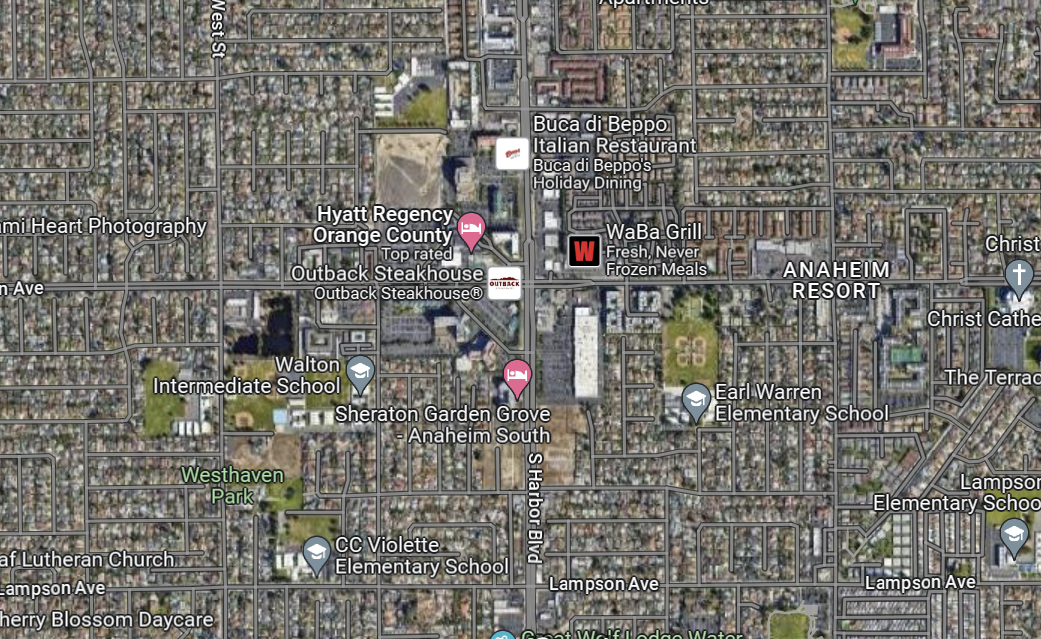

Label: 0


In [2]:
from PIL import Image
from IPython.display import display

img = train_ds[0]['image']
print("Surface Roughtness B Image: ")
display(img)
label = train_ds[0]['label']
print("Label:", label)

Loading from your local dataset folder

- you can upload your own dataset as well. The data should be stored in a seperate folder called `data`.
- Folder Structure:
    - data
        - train
            - Roughness B
                - imgs
            - Roughness C
                - imgs
            - Roughness D
                - imgs
        - validation
            - same as train folder
        - test
            - same as train folder
- load the dataset from local file directory using the "imageFolder"
- uncomment and run the following cell to load. <br>
*double check your relative data_directory path

In [3]:
## `./data` is the relative path to your data folder
# dataset = load_dataset("imagefolder", data_dir = "./data")
# train_ds = dataset['train']
# val_ds = dataset['validation']
# test_ds = dataset['test']

Currently, the class label field are still strings as seen from below example. We need to encode them to integers for ease of training

In [4]:
train_ds.features["label"]

ClassLabel(names=['RoughnessB', 'RoughnessC', 'RoughnessD'], id=None)

Create a `label2id` object to encode the label string into integers. And a `id2label` to decode the class index back to label strings. 

In [5]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'RoughnessB', 1: 'RoughnessC', 2: 'RoughnessD'}

In [6]:
id2label[2]

'RoughnessD'

## Data Preparation

Before feeding our dataset into the vision model, we need to preprocess and format the data in a way the model can interpret, which essentially means converting it into numerical form.

An important step in this process is normalizing the dataset. In our case, normalization involves the following:

1. Resizing all images to a specific size, matching the dimensions used by the pre-trained model.
1. Normalizing each color channel (R, G, B) using the mean and standard deviation associated with the pre-trained model architecture that we are using: `google/vit-base-patch16-224-in21k`.
1. Converting pixel values into tensors (numerical data) that the model can process.

For image-based tasks, `data augmentation` during training is very common. Techniques such as random cropping and flipping can be applied to artificially expand the training set. This help address the need for collecting more data, which can be costly and time-consuming. Moreover, data augmentation often leads to a more robust model and improved accuracy. 

While there are many benefits to augument data, it is important to also note that the augmented data should still represent plausible variations of the original data. This ensures the model learns to handle real-world scenarios effectively."

In [7]:
from transformers import ViTImageProcessor

# loading the visual model processor
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [8]:
# importing the mean, standard deviation, and sizes from the pre-trained model
image_mean = processor.image_mean
image_std = processor.image_std
size = (processor.size["height"], processor.size["width"])
crop_size = size
max_size = None

The Datasets library is designed to simplify data processing. It allows us to create custom functions that can be applied to an entire dataset using either `.map()` or .`set_transform()`.

In this case, we define two separate functions: one for training (which includes data augmentation) and another for validation and test dataset (which involves resizing, center cropping, and normalizing).

In [9]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)

normalize = Normalize(mean=image_mean, std=image_std)


_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

Applying transformation to the dataset

In [10]:
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

The dataset now has a third column `pixel_values` for passing into our vision model. Let's inspect what we've added to the `pixel_value` column 

In [11]:
print("Dataset keys:\n", train_ds[0].keys())
print("pixel_values:\n", train_ds[0]['pixel_values'])

Dataset keys:
 dict_keys(['image', 'label', 'pixel_values'])
pixel_values:
 tensor([[[-0.4353, -0.2941,  0.3333,  ..., -0.0275, -0.1529, -0.0431],
         [ 0.0588, -0.2392,  0.5059,  ..., -0.0745, -0.1843, -0.0510],
         [ 0.2078, -0.2157,  0.1922,  ..., -0.0745, -0.3020, -0.1765],
         ...,
         [ 0.0745,  0.0667, -0.0118,  ..., -0.2549, -0.1765, -0.0510],
         [ 0.0980,  0.0275, -0.1294,  ..., -0.3882, -0.1608, -0.0588],
         [ 0.0118, -0.0275, -0.0588,  ..., -0.4275, -0.1529, -0.0902]],

        [[-0.4353, -0.2941,  0.3333,  ..., -0.1059, -0.2157, -0.0980],
         [ 0.0588, -0.2392,  0.5059,  ..., -0.1608, -0.2549, -0.0980],
         [ 0.2078, -0.2157,  0.1922,  ..., -0.1686, -0.3725, -0.2235],
         ...,
         [ 0.0824,  0.0824,  0.0118,  ..., -0.2235, -0.1608, -0.0431],
         [ 0.1059,  0.0353, -0.1059,  ..., -0.3725, -0.1373, -0.0431],
         [ 0.0196, -0.0275, -0.0667,  ..., -0.4431, -0.1373, -0.0588]],

        [[-0.4196, -0.2863,  0.3412,  ..

## Training the Model

We are ready to train our model now that we have the dataset taken care of. 

In [12]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning indicates that we are discarding some weights (specifically, the weights and bias of the classifier layer) and randomly initializing others (the weights and bias of a new classifier layer). This is expected in our situation because we are adding a new head to the model for which we don't have pre-trained weights. The library is simply reminding us that we should fine-tune the model before using it for inference, which is what we will do next.

To instantiate a `Trainer`, we need to define the training configuration and evaluation metrics. The key component here is the TrainingArguments class, which contains all the attributes needed to customize the training process. It requires a folder name where the model's checkpoints will be saved.

Most of the training arguments are straightforward, but an important one in this context is remove_unused_columns=False. This setting prevents the removal of features not used by the model's call function. By default, this is set to True to drop unused feature columns, simplifying the input unpacking for the model's call function. However, in our case, we need to retain the unused features (especially 'image') to generate 'pixel_values'.

You can use below code to check the number of trainable parameters in for this model

In [13]:
num_trainable_params = sum(p.numel() for p in model.parameters())

print("Number of trainable parameters:", num_trainable_params/1000000, "million")

Number of trainable parameters: 85.800963 million


In [14]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"
#If your batch size is too large to fit into your local GPU memory, use smaller batch size.
batch_size= 5

args = TrainingArguments(
    f"vit-base-patch16-224-in21k-fintuned-SurfaceRoughness", # your trained model name. Could be any of your choice.
    overwrite_output_dir=True,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=6, # number of times going through the entire dataset
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
#     push_to_hub=True,
)

/home/szheng/miniconda3/envs/pytorch/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In the above code, we have:
* Set the evaluation to be done at the end of each epoch
    * `save_strategy="epoch"`
    * `evaluation_strategy="epoch"`
* tweak the learning rate
    * `learning_rate=2e-5`
* tweak the bactch_size that suits your local gpu
    * `per_device_train_batch_size=batch_size`
    * `per_device_eval_batch_size=batch_size`
* define a weight decay
    * `weight_decay=0.01`
* customize the number of epochs for training 
    * `num_train_epochs=6`
* Ask the Trainer to load the best model it saved (according to metric_name) at the end of training since the best model might not be the one at the end of training.
    * `metric_for_best_model=metric_name`

All of the above arguments are also known as `hyperparameters`. They are the settings or configurations that you define before training a machine learning model. Unlike parameters, which are learned during training (like the `weights` and `biases`), hyperparameters control the learning process and influence how the model is trained and how it performs.

The below `collate_fn` is used to batch examples together for training. Each batch consists of 2 keys, namely `pixel_values` and `labels`. 

In [15]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=batch_size)

In [16]:
# Each batch has a shape of (batch_size, num_classes, pixel_value_width, pixel_value_height) like shown below 
batch = next(iter(train_dataloader))
for k,v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)

pixel_values torch.Size([5, 3, 224, 224])
labels torch.Size([5])


In [17]:
from sklearn.metrics import accuracy_score
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and labels, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

Then we just need to pass all of this along with our datasets to the Trainer:

In [18]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

You might wonder why we pass along the `processor` as a tokenizer when we already preprocessed our data. This is only to make sure the image processor configuration file (stored as JSON) will also be uploaded to the repo on the hub.

Now we can finetune our model by calling the train method:

### Training

In [19]:
trainer_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.052295,0.466667
2,No log,1.004315,0.733333
3,No log,0.961275,0.800000
4,No log,0.935349,0.733333
5,No log,0.915392,0.733333
6,No log,0.905790,0.733333


In [20]:
# saving the model 
trainer.save_model()
trainer.log_metrics("train", trainer_results.metrics)
trainer.save_metrics("train", trainer_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =        6.0
  total_flos               = 28579591GF
  train_loss               =     0.8642
  train_runtime            = 0:00:27.16
  train_samples_per_second =     14.577
  train_steps_per_second   =      3.092


In [31]:
# Running prediction on the validation set
outputs = trainer.predict(val_ds)
print(outputs.metrics)

{'test_loss': 0.857232928276062, 'test_accuracy': 1.0, 'test_runtime': 0.6825, 'test_samples_per_second': 13.187, 'test_steps_per_second': 2.931}


Using sklearn.metris to visualize the prediction on validation set 

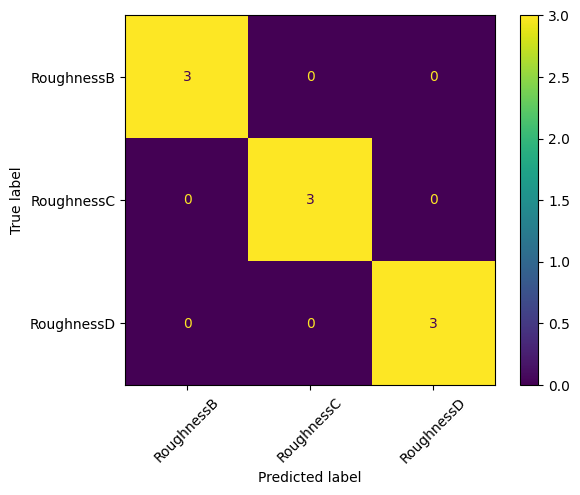

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

## Using Finetuned Models 

Loading the local model that you saved 

In [32]:
from PIL import Image
from transformers import AutoModelForImageClassification, AutoImageProcessor

## The local_model_path is what you pass in to the training argument earlier
local_model_path = './vit-base-patch16-224-in21k-fintuned-SurfaceRoughness'

image_processor = AutoImageProcessor.from_pretrained(local_model_path)
model = AutoModelForImageClassification.from_pretrained(local_model_path)

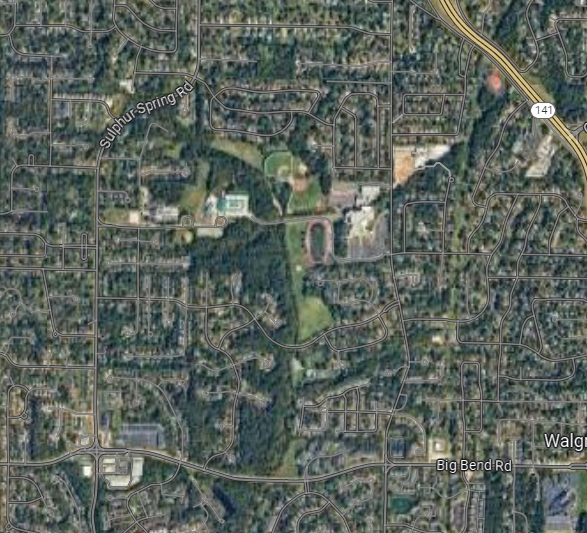

In [51]:
# Loading an image that our model hasn't seen before
new_ds = load_dataset('sh-zheng/Test_SurfaceRoughness_Dataset')
eval_image = new_ds['train'][0]['image'].convert("RGB")
eval_image

In [52]:
# prepare image for the model
encoding = image_processor(eval_image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [53]:
import torch

# forward pass
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: RoughnessB


Hooray! Successfully predicted `surface roughness B` based on the snipshot from google Aerial view. 

Now try it with your own images!

## References:

https://github.com/huggingface/notebooks/blob/main/examples/image_classification.ipynb